# Decomposing Time Series Data With Singular-Spectrum Analysis

This tutorial will introduce the technique of **singular-spectrum analysis (SSA)**, a method of time series decomposition that has received little attention on Kaggle. This is surprising, as there is ongoing demand for techniques that can be used to explore, analyse and process time series data, the recent [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting) competition being one example.

Put simply, SSA decomposes a time series into a set of summable components that are grouped together and interpreted as *trend*, *periodicity* and *noise*. SSA emphasises **separability** of the underlying components, and can readily separate periodicities that occur on different time scales, even in very noisy time series data. The original time series is recovered by summing together all of its components.

Thus, SSA can be used to analyse and reconstruct a time series with or without different components as desired. For example, you could apply SSA to:
* construct a smoothed version of a time series using a small subset of its components; 
* investigate a time series' periodic components to understand the underlying processes that generated the time series;
* reconstruct the original time series without its periodic components;
* remove all trend and periodic components from the series, leaving just the 'noise', which may be meaningful in and of itself...

and so on and so forth. Unlike the commonly used autoregressive integrated moving average (ARIMA) method, SSA makes no assumptions about the nature of the time series, and has just a single adjustable (and easily interpretable) parameter. Further, the base algorithm requires little more than a few lines of `numpy` linear algebra to implement, so you can easily roll your own bespoke SSA implementation if you desire.

## The Purpose of This Kernel
I intend this kernel to not only introduce and demonstrate the SSA method, but also present its theory and Python implementation. I will present theory and its corresponding code in tandem, bridging the gap between mathematical underpinning and practical algorithmic implementation. While R and Python packages for SSA are available (e.g. [Rssa](https://cran.r-project.org/package=Rssa) and [pySSA](https://github.com/aj-cloete/pySSA)), I feel there is more to be gained when the inner workings of a given statistical/analytical technique are understood, instead of relying on a few subroutines from a package.

SSA will be applied to mock time series data to demonstrate its key abilities, illustrate where it excels and falls down, and document potential pitfalls along the way. SSA will then be applied to a real-world time series taken from the dataset, [MotionSense Dataset : Smartphone Sensor Data](https://www.kaggle.com/malekzadeh/motionsense-dataset). This will not be an extensive analysis of the MotionSense dataset, but will instead highlight the ability of SSA to extract underlying periodicities in a noisy, complex time series.

Overall, I hope that these elementary studies of the SSA technique will provide a solid foundation for others to successfully apply SSA to real-world time series data.

## Outline
In [Section 1](#Section1), I will define a simple, illustrative toy time series that consists of trend, periodic and noise elements. This time series will be used to demonstrate the workings of the SSA method over the next several sections.

[Section 2](#Section2) introduces the SSA method and translates its formal steps into a practical Python implementation. As we go, I will apply SSA to our toy time series, and intermediate results will be plotted and discussed. At the heart of this section is the acclaimed singular value decomposition. 

[Section 3](#Section3) focuses on the notion of separability in SSA, and how it is quantified. Once again, the formal mathematics will be translated into Python, and applied to the toy time series.

[Section 4](#Section4) will bring together the code developed in Sections 2 and 3, creating a simple Python SSA class that will be used in the rest of the kernel (and future kernels).

[Section 5](#Section5) investigates the effect of the window length parameter on the decomposition of the toy time series. 

[Section 6](#Section6) applies SSA to real-world time series data from the [MotionSense](https://www.kaggle.com/malekzadeh/motionsense-dataset) dataset. I also propose a hypothetical use for SSA with this dataset. 

[Section 7](#Section7) contains a few concluding words.

## Contents
[1. A Toy Time Series](#Section1) <br>
[2. Introducing the SSA Method](#Section2) <br>
&nbsp; &nbsp; &nbsp;[2.1 From Time Series to Trajectory Matrix](#Section2.1) <br>
&nbsp; &nbsp; &nbsp;[2.2 Decomposing the Trajectory Matrix](#Section2.2) <br>
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp; [2.2.1 The $\mathbf{U}$ Matrix](#Section2.2.1) <br>
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp; [2.2.2 The $\mathbf{V}$ Matrix](#Section2.2.2) <br>
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp; [2.2.3 The $\mathbf{\Sigma}$ Matrix](#Section2.2.3) <br>
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp; [2.2.4 The Rank of the Trajectory Matrix](#Section2.2.4) <br>
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp; [2.2.5 Putting it all Together](#Section2.2.5) <br>
&nbsp; &nbsp; &nbsp;[2.3 Reconstructing the Time Series](#Section2.3) <br>
[3. Time Series Component Separation and Grouping](#Section3) <br>
[4. A Python Class for SSA](#Section4) <br>
[5. The Window Length](#Section5) <br>
&nbsp; &nbsp; &nbsp; [5.1 $L=2$](#Section5.1) <br>
&nbsp; &nbsp; &nbsp; [5.2 $L=5$](#Section5.2) <br>
&nbsp; &nbsp; &nbsp; [5.3 $L=20$](#Section5.3) <br>
&nbsp; &nbsp; &nbsp; [5.4 $L=40$](#Section5.4) <br>
&nbsp; &nbsp; &nbsp; [5.5 $L=60$](#Section5.4) <br>
[6. MotionSense: Applying SSA to Accelerometer Data](#Section6) <br>
&nbsp; &nbsp; &nbsp;[6.1 Loading the Data](#Section6.1) <br>
&nbsp; &nbsp; &nbsp;[6.2 Plotting the Data](#Section6.2) <br>
&nbsp; &nbsp; &nbsp;[6.3 Decomposing the Time Series with SSA](#Section6.3) <br>
&nbsp; &nbsp; &nbsp;[6.4 Using SSA to Extract an Individual's Walking 'Signature'](#Section6.4) <br>
&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;[6.4.1 Data Extraction and Processing](#Section6.4.1) <br>
&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;[6.4.2 Comparison of Walk 'Signatures'](#Section6.4.2) <br>
[7. Some Final Words](#Section7) <br>
## Python Setup
This kernel requires only the standard `numpy`, `matplotlib` and `pandas` modules:

In [2]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

# 1. A Toy Time Series <a name="Section1"></a>
To demonstrate the workings and concepts of SSA, we'll first define an arbitrary, toy time series, $F = \{f_0, f_1, \ldots, f_{N-1}\}$, containing trend, periodic and noise components:

$$f_t = 0.001 \times (t - 100)^2 + 2\sin(\frac{2\pi t}{p_1}) + 0.75\sin(\frac{2\pi t}{p_2}) + \text{Rand}\{-1,1\}$$

where $t = \{0, 1,\ldots, N-1\}$ is a discrete time moment, $p_1$ and $p_2$ are set time periods and $\text{Rand}\{-1,1\}$ is a random number uniformly distributed between –1 and 1.

The $0.001 \times (t - 100)^2$ term defines the (parabolic) trend of the series,  $2\sin(\frac{2\pi t}{p_1})$ and $0.75\sin(\frac{2\pi t}{p_2})$ are two periodic components with differing periodicities and amplitudes, while $\text{Rand}\{-1,1\}$ introduces noise.
Let's take a look:

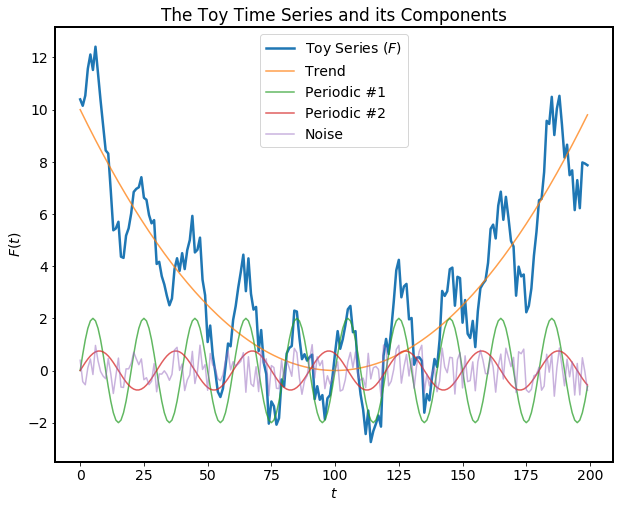

In [3]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

Based on visual inspection, the presence of trend (orange), periodic (green) and noise (purple) components in the time series is clear. However, the second periodic component (red) in the toy series is not apparent. Could we use SSA to recover the trend, periodic and noise components from the toy time series?

# 2. Introducing the SSA Method<a name="Section2"></a>
The notation in this section will mostly follow that used in the book, [*Analysis of Time Series Structure: SSA and Related Techniques*](https://www.crcpress.com/Analysis-of-Time-Series-Structure-SSA-and-Related-Techniques/Golyandina-Nekrutkin-Zhigljavsky/p/book/9781584881940) by N. Golyandina, V. Nekrutkin and A. Zhigljavsky—an excellent reference containing more proofs and details about SSA than you could possibly ever need to know. Here, we'll go a step further and develop a Python implementation for SSA. For consistency between the mathematical notation and the code, all matrix and summation indexing with begin at 0 instead of 1.

## 2.1 From Time Series to Trajectory Matrix<a name="Section2.1"></a> 
The first step of SSA is to map the time series $F$ to a sequence of multi-dimensional lagged vectors. Let an integer $L$ be the **window length**, $2 \le L \le N/2$. We form a 'window', given by the subseries $\{f_i, \ f_{i+1}, \ldots , \ f_{i+L-1}\}$, for  $i=0,\ldots,N-L$. We slide this window along the time series, forming a column vector, $X_i$, for each subseries. That is, we have

\begin{align*}
X_0 & = (f_0, \ f_1, \ f_2,  \ldots, \ f_{L-1} )^{\text{T}} \\
X_1 & = (f_1, \ f_2, \ f_3,  \ldots, \ f_L )^{\text{T}} \\
X_2 & = (f_2, \ f_3, \ f_4,  \ldots, \ f_{L+1} )^{\text{T}} \\
X_3 & = (f_3, \ f_4, \ f_5,  \ldots, \ f_{L+2} )^{\text{T}} \\
& \quad \quad \quad  \vdots \\
X_{N-L} & = (f_{N-L}, \ f_{N-L+1}, \ f_{N-L+2}, \ \ldots, \ f_{N-1} )^{\text{T}}.
\end{align*}

These column vectors form the $L$-*trajectory matrix*, $\mathbf{X}$, of the time series (hereafter just *trajectory matrix*):

$$\mathbf{X} = \begin{bmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\ 
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\ 
\end{bmatrix}$$

From writing out the matrix above, it is clear that the elements of the *anti-diagonals* (that is, the diagonals running from bottom-left to top-right) are equal. This type of matrix is known as a ***Hankel*** matrix.

For our toy time series, I'll set the window length to 70, and defer discussion on how to select an appropriate window length. Let $K = N - L + 1$ represent the number of columns in the trajectory matrix. **We'll refer to the columns of $\mathbf{X}$ as the $L$-lagged vectors, and the rows as $K$-lagged vectors.**

In [4]:
L = 70 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

Let's take a moment to appreciate the trajectory matrix in all its anti-diagonal glory:

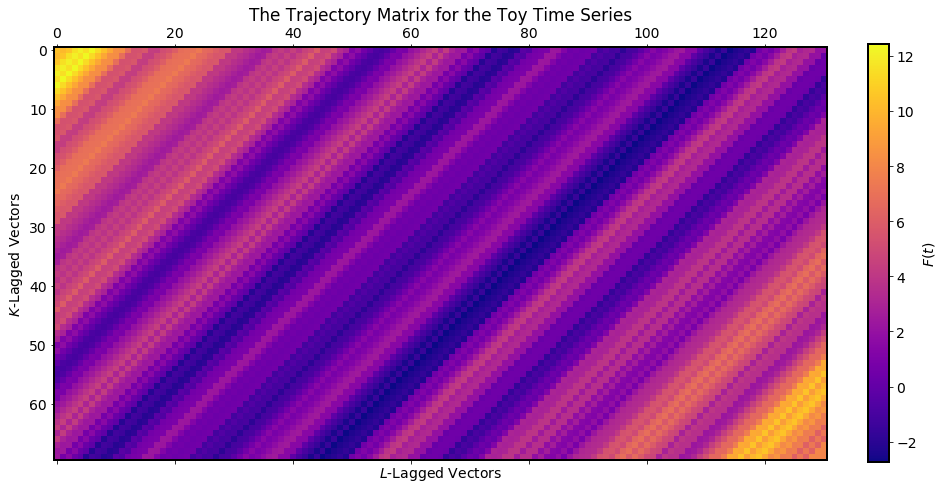

In [5]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

## 2.2 Decomposing the Trajectory Matrix<a name="Section2.2"></a>
The second step is decomposing the trajectory matrix with a [singular-value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition),

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$ 
where:
* $\mathbf{U}$ is an $L \times L$ unitary matrix containing the orthonormal set of ***left singular vectors*** of $\mathbf{X}$ as columns;
* $\mathbf{\Sigma}$ is an $L \times K$ rectangular diagonal matrix containing $L$ ***singular values*** of $\mathbf{X}$, ordered from largest to smallest; and
* $\mathbf{V}$ is a $K \times K$ unitary matrix containing the orthonormal set of ***right singular vectors*** of $\mathbf{X}$ as columns.

The SVD of the trajectory matrix can be rewritten as 
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
where $\sigma_i$ is the $i$th singular value, $U_i$ and $V_i$ are vectors representing the $i$th columns of $\mathbf{U}$ and $\mathbf{V}$, respectively, $d \le L$ is the *rank* of the trajectory matrix (which I shall elaborate on shortly), and $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$ is the $i$th ***elementary matrix*** of $\mathbf{X}$. The collection $\{U_i, \sigma_i, V_i\}$ will be denoted the $i$th ***eigentriple*** of the SVD.

To build a picture of what all of this means, let's inspect the $\mathbf{U}$, $\mathbf{V}$ and $\mathbf{\Sigma}$ matrices in turn. 

### 2.2.1 The $\mathbf{U}$ Matrix<a name="Section2.2.1"></a>
$\mathbf{U}$ is an $L \times L$ matrix whose columns are orthonormal, that is
$$
    U_i \cdot U_j = \left\{
  \begin{array}{lr}
    1 \ & i = j \\
    0 \ & i \ne j
  \end{array}
\right.
$$
This means that $\mathbf{UU}^{\text{T}} = \mathbf{U}^{\text{T}}\mathbf{U} = \mathbf{1}$, making $\mathbf{U}$ a unitary matrix. 

To elucidate the role that $\mathbf{U}$ plays in the expansion for $\mathbf{X}$ above, let $Z_i = \sigma_i V_i$ be a column vector, so that
$$\mathbf{X} = \sum_{i=0}^{d-1} U_i Z_i^{\text{T}}$$
and each $L$-lagged column vector, $X_j$, is then given by
$$X_j = \sum_{i=0}^{d-1}z_{j,i}U_i$$
where $z_{j,i}$ is the $j$th component of the vector $Z_i$. The expression for $X_j$ suggests that $\mathcal{U} = \{U_0,  
 \ldots, U_{d-1} \}$ is a basis set spanning the *column space* of the trajectory matrix, and $z_{j,i}$ is the $i$th coefficient of the lagged vector $X_j$ represented in the basis $\mathcal{U}$. **In other words, the columns of the $\mathbf{U}$ matrix form an orthonormal basis set that describes the time subseries $\left\{ f_i, \ldots, f_{i+L-1}\right\}_{i=0}^{N-L}$ in the columns of the trajectory matrix.**  

### 2.2.2 The $\mathbf{V}$ Matrix<a name="Section2.2.2"></a>
The matrix $\mathbf{V}$—appearing (by convention) as its transpose in the expression for the SVD of $\mathbf{X}$—is a $K \times K$ matrix with orthonormal columns, which, like the $\mathbf{U}$ matrix, makes it unitary.

To interpret the columns of $\mathbf{V}$ in the SVD of the trajectory matrix, we first note that for any appropriately shaped matrices $\mathbf{A}$ and $\mathbf{B}$, $\left(\mathbf{AB}\right)^{\text{T}} = \mathbf{B}^{\text{T}}\mathbf{A}^{\text{T}}$. Taking the transpose of $\mathbf{X}$, we therefore have
\begin{align*}
\mathbf{X}^{\text{T}} & = \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
                      & = \sum_{i=0}^{d-1}V_i Y_i^{\text{T}}
\end{align*}
where we have set $Y_i = \sigma_i U_i$. Then,
$$X^{(\text{T})}_j = \sum_{i=0}^{d-1}y_{j,i}V_i$$ 
where $X^{(\text{T})}_j$ is the $j$th column of $\mathbf{X}^{\text{T}}$, and $y_{j,i}$ is the $j$th component of the vector $Y_i$. This expression suggests that the $\mathcal{V} = \{V_0, \ldots, V_{d-1}\}$ is a basis set spanning the column space of $\mathbf{X}^{\text{T}}$, and $y_{j,i}$ is the $i$th coefficient of the lagged vector $X^{(\text{T})}_j$ represented in the basis $\mathcal{V}$. Equivalently, $\mathcal{V}$ is a basis set spanning the *row space* of $\mathbf{X}$. **That is, the columns of the $\mathbf{V}$ matrix form an orthonormal basis set that describe the time subseries $\{ f_i, \ldots, f_{i+N-L}\}_{i=0}^{L-1}$ in the rows of the trajectory matrix.**


### 2.2.3 The $\mathbf{\Sigma}$ Matrix<a name="Section2.2.3"></a>
The $\mathbf{\Sigma}$ matrix is an $L \times K$ rectangular diagonal matrix containing the **singular values** of $\mathbf{X}$. The singular values are ordered from largest to smallest, i.e. $\sigma_0 \ge \sigma_1 \ge \ldots \ge \sigma_{L-1} \ge 0$. **We can interpret $\sigma_i$ as a scaling factor that determines the relative importance of the eigentriple $(U_i, \sigma_i, V_i)$ in the expansion $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}}$.**

The *Frobenius norm* of $\mathbf{X}$, $\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}$, is given by
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}} = \sqrt{\sum_{j=0}^{L-1}\sum_{k=0}^{K-1} \lvert x_{j,k}\rvert^2}$$
where $x_{j,k}$ denotes the element in the $j$th row and $k$th column of $\mathbf{X}$. 

Let's turn our attention to the elementary matrices $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$. Now, for an outer product such as $U_i V_i^{\text{T}}$, we have  $\lvert \lvert U_i V_i^{\text{T}} \rvert \rvert_{\text{F}} = \lvert \lvert U_i \rvert \rvert_{\text{F}} \lvert \lvert V_i \rvert \rvert_{\text{F}}$, which is simply equal to 1 due to $U_i$ and $V_i$ being normalised. From this result, it is then clear that $\lvert\lvert \mathbf{X}_i \rvert\rvert_{\text{F}} = \sigma_i$. It also turns out that 
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2 = \sum_{i=0}^{d-1} \sigma_i^2$$
i.e. **the squared Frobenius norm of the trajectory matrix is equal to the sum of the squared singular values. This suggests that we can take the ratio $\sigma_i^2 / \lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2$ as a measure of the contribution that the elementary matrix $\mathbf{X}_i$ makes in the expansion of the trajectory matrix.**

Further, if we right-multiply the original SVD of $\mathbf{X}$ by $\mathbf{X}^{\text{T}}$:
\begin{align*}
    \mathbf{XX}^{\text{T}} & = \mathbf{U\Sigma V}^{\text{T}}\mathbf{X}^{\text{T}} \\
               & = \mathbf{U\Sigma V}^{\text{T}} \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
               & = \mathbf{U\Sigma} \mathbf{\Sigma}^{\text{T}}\mathbf{U}^{\text{T}}
\end{align*}
Letting the square diagonal matrix $\mathbf{\Sigma}^2 = \mathbf{\Sigma \Sigma}^{\text{T}}$, and multiplying on the right by $\mathbf{U}$, gives
$$(\mathbf{XX}^{\text{T}})\mathbf{U} = \mathbf{U}\mathbf{\Sigma}^2$$
which—given that $\mathbf{\Sigma}^2$ is a diagonal matrix with elements $\sigma_i^2$—demonstrates that the columns of $\mathbf{U}$ are eigenvectors of the matrix $\mathbf{XX}^{\text{T}}$, with eigenvalues $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$. Following a similar argument, multiplying $\mathbf{X}$ on the left by $\mathbf{X}^{\text{T}}$ shows that the columns of $\mathbf{V}$ are eigenvectors of the matrix $\mathbf{X}^{\text{T}}\mathbf{X}$, also with eigenvalues $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$.


### 2.2.4 The Rank of the Trajectory Matrix<a name="Section2.2.4"></a>
We are now equipped to talk about the *rank*, $d$, of the trajectory matrix. The columns of the trajectory matrix are a sequence of $L$-lagged vectors, which span the *trajectory space* of the time series. This space will be at most $L$-dimensional; however, if the columns in $\mathbf{X}$ are linearly dependent, then the trajectory space will have $d < L$ dimensions. This manifests as one or more zero singular values in $\mathbf{\Sigma}$. **The rank of $\mathbf{X}$ is the maximum value of $i$ such that $\sigma_i > 0$. Put another way, $d = \text{rank}\{\mathbf{X}\}$ can be regarded as the instrinsic dimensionality of the time series' trajectory space.**

(Note: for noisy real-world time series data, the trajectory space is likely to have $d = L$ dimensions.)

It is important to note that each elementary matrix $\mathbf{X}_i$ has a rank of 1, and that the matrix 
$$\mathbf{X}^{(r)} = \sum_{i=0}^{r} \mathbf{X}_i$$
for $r < d$, is the best rank-$r$ approximation to the trajectory matrix $\mathbf{X}$, such that $\lvert\lvert \mathbf{X} - \mathbf{X}^{(r)}\rvert\rvert_F$ is minimised. **That is, we can sum the first $r$ elementary matrices to obtain an optimal, lower-dimensional approximation of $\mathbf{X}$**.

### 2.2.5 Putting it all Together<a name="Section2.2.5"></a>
Let's quickly recap everything so far: we have mapped a time series $F = \{f_0, \ldots, f_{N-1}\}$ to a collection of multi-dimensional lagged vectors, $X_i = (f_i, f_{i+1}, \ldots, f_{i+L-1})^{\text{T}}, i = 0, \ldots, N-L$, which together comprise the columns of the trajectory matrix $\mathbf{X}$. We then decomposed this matrix with an SVD; in doing so, we found two orthonormal basis sets, $\mathcal{U}$ and $\mathcal{V}$, which span the column- and row-space, respectively, of the trajectory matrix. The SVD of $\mathbf{X}$ can be written as
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
where $\mathbf{X}_i$ is the $i$th elementary matrix of $\mathbf{X}$, determined by the eigentriple  $\{U_i, \sigma_i, V_i\}$. The $i$th singular value, $\sigma_i$, determines the relative contribution of $\mathbf{X}_i$ in the expansion of $\mathbf{X}$ above. The integer $d \le L$ is the intrinsic dimensionality of the time series' trajectory space, and we may choose to obtain a lower-dimensional approximation of $\mathbf{X}$ by summing only the first $r < d$ elementary matrices.

Much of what we've covered so far is general to the SVD of *any* matrix, not just the trajectory matrix of a time series. From now on, we are going to focus on reconstructing the components of a time series from its elementary matrices. In practice, the steps involved are quite simple.

Enough chat—let's decompose the trajectory matrix and form its elementary matrices:

In [6]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

Let's take a peak at the first 12 elementary matrices.

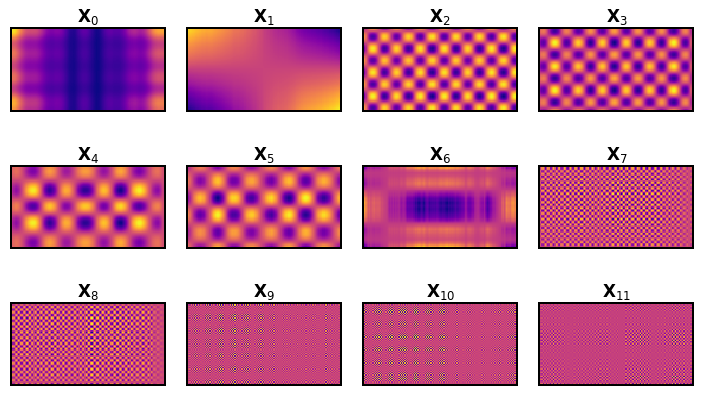

In [7]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

From visual inspection of the $\mathbf{X}_i$ above, it is obvious that the elementary matrices lack the anti-diagonal structure of the trajectory matrix. Without inspecting the $U_i$ vector associated with each $\mathbf{X}_i$, or reconstructing a time series of each component, the appearance of the $\mathbf{X}_i$ hints at the nature of each component, be it trend, periodicity or noise. For example, the $L$- and $K$-lagged vectors in $\mathbf{X}_0$ and $\mathbf{X}_1$ vary relatively slowly across the matrix, suggesting that $\mathbf{X}_0$ and $\mathbf{X}_1$ may be associated with the overall trend in the time series. The matrices $\mathbf{X}_2$ to $\mathbf{X}_5$ show large checkerboard patterns, suggesting periodicity. $\mathbf{X}_6$ may lie somewhere between periodicity and trend. The matrices of $\mathbf{X}_7$ onwards (and all the way up to $\mathbf{X}_{69}$) appear to alternate quickly between a few values; these elementary matrices are likely to be associated with the noise in the original time series.

(Exercise: re-run the several cells above, excluding the noise from the toy time series $F$. What happens to the number of elementary matrices? What is the intrinsic dimensionality of the noiseless series' trajectory space? For a laugh, re-run the cells with just the noise component in $F$, and note the resulting elementary matrices. Knowing that the 'process' that generated this time series is random, do you think these elementary matrices individually contain any useful information?) 

Let's plot the relative contributions, $\dfrac{\sigma_i^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, and the cumulative contributions, $\dfrac{\sum_{j=0}^i \sigma_j^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, of the first 12 elementary matrices to the trajectory matrix of the toy time series:

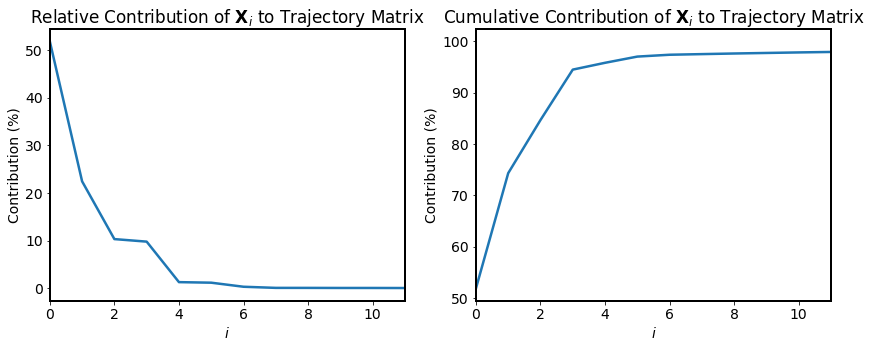

In [8]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

The plots above depict the relative and cumulative contributions of the first 12 $\mathbf{X}_i$ in the expansion $\mathbf{X} = \sum_{i=0}^{d-1}\mathbf{X}_i$. The elementary matrices $\mathbf{X}_0$ and $\mathbf{X}_1$ contribute 52% and 22%, respectively, to the expansion of  $\mathbf{X}$. Together, the first seven elementary matrices contribute 97%. Elementary matrices that make equal contributions to the expansion (that is, $\sigma_i \approx \sigma_{i+1}$) are likely to be grouped together when reconstructing the time series, and appear as "breaks" in the plot of relative contributions. For example, the "breaks" in the plot above suggest that $\mathbf{X}_2$ and $\mathbf{X}_3$, and $\mathbf{X}_4$ and $\mathbf{X}_5$, should be grouped together. 

It is important to note that the elementary matrices represent an optimal (although possibly non-unique) separation of components in trajectory space: by definition, the rows and columns of one elementary matrix are orthogonal to the rows and columns of the other elementary matrices. However, this separation may not coincide with what we would consider a useful, interpretable 'component' of the time series. In fact, there are restrictions on the types of time series components that are exactly separable under this formalism.

## 2.3 Reconstructing the Time Series<a name="Section2.3"></a>
So far, we have mapped a time series $F$ to a series of $L$-lagged vectors, forming the *trajectory matrix* of $F$. We then decomposed this matrix with a singular-value decomposition, and constructed a set of *elementary matrices* which comprise the trajectory matrix. We then gave a bit of a hand-waving explanation to classify these elementary matrices as *trend*, *periodicity* and *noise*. 

In a perfect world, all the components of a time series $F = \sum_j F^{(j)}$ would be separable, and we would have grouped the the resulting elementary matrices $\mathbf{X}_i$ appropriately, such that
\begin{align*}
\mathbf{X} &  = \sum_{k \in \mathcal{S}}\mathbf{X}_k + \sum_{l \in \mathcal{T}}\mathbf{X}_l + \ldots \\
             &  = \sum_j \mathbf{X}^{(j)}
\end{align*}
where $\mathcal{S}$ and $\mathcal{T}$ are disjoint (i.e. non-overlapping) sets of indices, and $\mathbf{X}^{(j)}$ is the trajectory matrix of the time series component $F^{(j)}$. In this case, each $\mathbf{X}^{(j)}$ would have a Hankel structure like the original trajectory matrix, and construction of each $F^{(j)}$ would be simple. However, in this imperfect real world, no component trajectory matrices will have equal values on their anti-diagonals. Therefore, we seek a process to transform an elementary matrix to a Hankel matrix, and then into a time series.

To extract a time series from the elementary matrices, we'll employ ***diagonal averaging***, which defines the values of the reconstructed time series $\tilde{F}^{(j)}$ as averages of the corresponding anti-diagonals of the matrices $\mathbf{X}^{(j)}$. Formally, this is represented by introducing the *Hankelisation* operator, $\hat{\mathcal{H}}$, that acts on the $L \times K$ matrix $\mathbf{X}^{(j)}$ to give a Hankel matrix $\mathbf{\tilde{X}}^{(j)}$; that is, 
$$\mathbf{\tilde{X}}^{(j)} = \hat{\mathcal{H}}\mathbf{X}^{(j)}$$ 
The element $\tilde{x}_{m,n}$ in $\mathbf{\tilde{X}}^{(j)}$, for $s = m+n$, is given by
$$
\tilde{x}_{m,n} = \left\{
  \begin{array}{lr}
    \frac{1}{s+1}\sum_{l=0}^{s} x_{l, s-l} & \ 0 \le s \le L-1 \\
    \frac{1}{L-1}\sum_{l=0}^{L-1} x_{l, s-l} & \ L \le s \le K-1 \\
    \frac{1}{K+L-s-1}\sum_{l=s-K+1}^{L} x_{l, s-l} & \ K \le s \le K+L-2 \\
  \end{array}
\right.
$$

At first glance, the above looks like an impenetrable soup of matrix indices. However, all it is doing is calculating the given $\tilde{x}_{m,n}$ by averaging the rest of the elements of the anti-diagonal wherein $\tilde{x}_{m,n}$ belongs. The number of anti-diagonal elements to sum depends on the location of $m$ and $n$ in the matrix, and hence the index soup. **In practice, we don't need the full Hankel matrix $\mathbf{\tilde{X}}^{(j)}$, and can cut straight to the construction of the time series $\tilde{F}^{(j)}$. However, I've included the definition of $\hat{\mathcal{H}}\mathbf{X}^{(j)}$ above to complete the mathematical exposition of SSA.**

It is important to note that $\hat{\mathcal{H}}$ is a linear operator, i.e.  $\hat{\mathcal{H}}(\mathbf{A} + \mathbf{B}) = \hat{\mathcal{H}}\mathbf{A} + \hat{\mathcal{H}}\mathbf{B}$. Then, for a trajectory matrix $\mathbf{X}$, 
\begin{align*}
\hat{\mathcal{H}}\mathbf{X} & = \hat{\mathcal{H}} \left( \sum_{i=0}^{d-1} \mathbf{X}_i \right) \\
                            &  = \sum_{i=0}^{d-1} \hat{\mathcal{H}} \mathbf{X}_i \\
                            &  \equiv \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}
\end{align*} 
As $\mathbf{X}$ is already a Hankel matrix, then by definition $\hat{\mathcal{H}}\mathbf{X} = \mathbf{X}$. Therefore, the trajectory matrix can be expressed in terms of its Hankelised elementary matrices:
$$\mathbf{X} = \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}$$
As a time series is uniquely determined from a Hankel matrix, the expression above also defines the time series $F$ as a sum of its components $\tilde{F}_i$. It is up to us to group these components together, and classify them as trend, periodicity or noise, and then we're free to decide how we use them. 

For fun, I've implemented a Hankelisation procedure below. However, don't get too attached to it, as it's going to be thrown away and replaced with something much more efficient and Pythonic.

In [9]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

We've come this far, so we might as well Hankelise a few elementary matrices of the toy time series while we're at it:

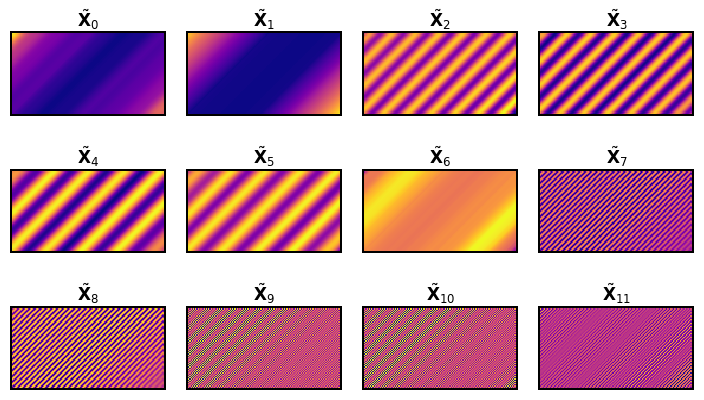

In [10]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Inspection of the Hankelised elementary matrices of the toy time series confirms our suspicians about the elementary matrices: $\tilde{\mathbf{X}}_0$ and $\tilde{\mathbf{X}}_1$ vary slowly over the whole time series, and can be grouped together as the trend component. $\tilde{\mathbf{X}}_2$ and $\tilde{\mathbf{X}}_3$ are both periodic, with the same frequency, and can be grouped as the first periodic component. $\tilde{\mathbf{X}}_4$ and $\tilde{\mathbf{X}}_5$ are also periodic, with a different frequency to $\tilde{\mathbf{X}}_2$ and $\tilde{\mathbf{X}}_3$, and will be grouped as the second periodic component. $\tilde{\mathbf{X}}_6$, lacking obvious periodicity, will be grouped with the trend components. We'll lump together all components from $\tilde{\mathbf{X}}_7$ and beyond as noise. To summarise:
\begin{align*}
\tilde{\mathbf{X}}^{\text{(trend)}} & = \tilde{\mathbf{X}}_0 + \tilde{\mathbf{X}}_1 + \tilde{\mathbf{X}}_6 
    & \implies &  \tilde{F}^{\text{(trend)}} = \tilde{F}_0 + \tilde{F}_1 + \tilde{F}_6 \\
\tilde{\mathbf{X}}^{\text{(periodic 1)}} & = \tilde{\mathbf{X}}_2 + \tilde{\mathbf{X}}_3 
    & \implies & \tilde{F}^{\text{(periodic 1)}} = \tilde{F}_2 + \tilde{F}_3  \\
\tilde{\mathbf{X}}^{\text{(periodic 2)}} & = \tilde{\mathbf{X}}_4 + \tilde{\mathbf{X}}_5 
    & \implies & \tilde{F}^{\text{(periodic 2)}} = \tilde{F}_4 + \tilde{F}_5\\
\tilde{\mathbf{X}}^{\text{(noise)}} & = \tilde{\mathbf{X}}_7 + \ldots + \tilde{\mathbf{X}}_{69}
    & \implies & \tilde{F}^{\text{(noise)}} = \tilde{F}_7 + \ldots + \tilde{F}_{69}
\end{align*}
While we have defined the time series component grouping in terms of Hankelised elementary matrices, we will no longer calculate the full Hankel matrix $\tilde{\mathbf{X}}_i$, and instead calculate $\tilde{F}_i$ directly from $\mathbf{X}_i$. Further, we'll do it with two lines of Python!

In [11]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

Let's go ahead and construct the first 12 elementary components, $\tilde{F}_i$, for the toy time series.

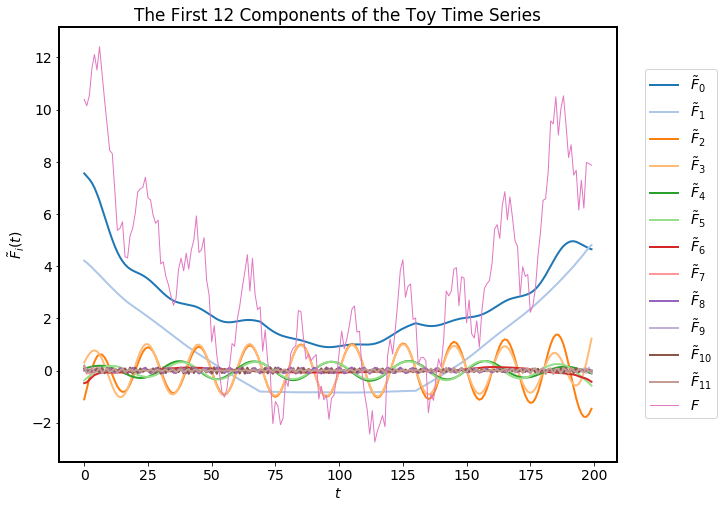

In [12]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

As mentioned earlier, the elementary components separated in the time series' trajectory space may not coincide with a single, interpretable component in the time series. For example, $\tilde{F}_0$ and $\tilde{F}_1$ both look vaguely like the trend—are they *really* separate components? Similarly, $\tilde{F}_2$ and $\tilde{F}_3$ are almost identical, except near the boundaries of the time series.

We'll introduce a way to quantify which $\tilde{F_i}$ should be grouped together, but for a moment, let's follow our instincts and apply our earlier grouping for $\tilde{F}^{\text{(trend)}}$,  $\tilde{F}^{\text{(periodic 1)}}$,  $\tilde{F}^{\text{(periodic 2)}}$ and  $\tilde{F}^{\text{(noise)}}$, and see how the SSA-separated components compare with the original components that compose the toy time series:

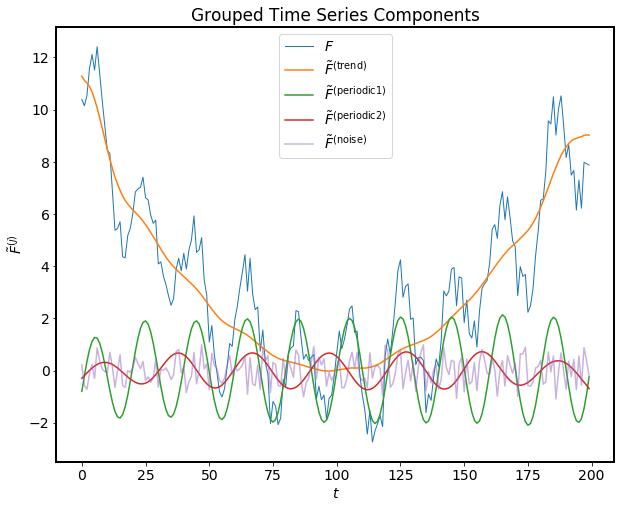

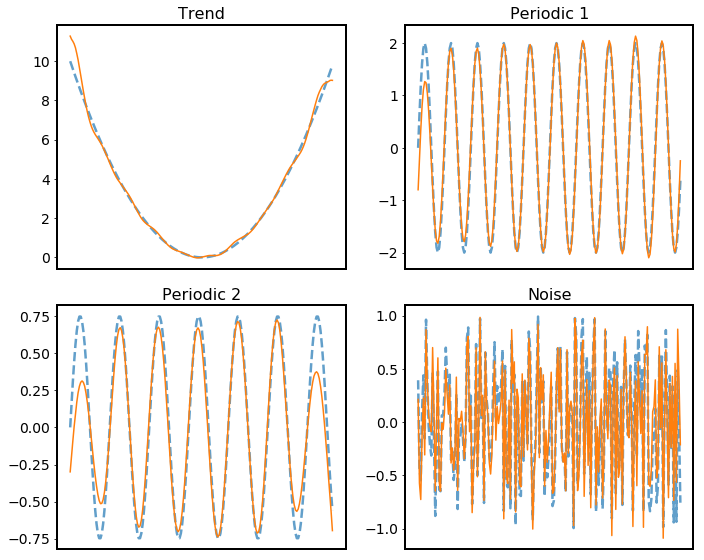

In [13]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0,1,6]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[2,3]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[7:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", trend, F_trend), 
              ("Periodic 1", periodic1, F_periodic1),
              ("Periodic 2", periodic2, F_periodic2),
              ("Noise", noise, F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

After we've grouped the elementary components together, it looks like SSA has done a great job separating the original components of the toy time series—especially the two periodic components with differing frequencies and amplitudes. However, the separation isn't perfect: all the components deteriorate near the boundaries, especially the trend and second periodic component. This is common in SSA, and arises from the fact that, under the SSA formalism, most types of series (i.e. polynomial, sine, exponential, etc.) are not exactly separable. Therefore, our attempt to recover the *exact* parabolic trend and periodic components from the toy series was always doomed to fail. 

However, that does not mean components of a time series cannot be *approximately separable*, as we witnessed above. (There is also the concept of *asymptotic separability*—when the length of the time series approaches infinity—however for practical reasons we will not consider that case here.)

# 3. Time Series Component Separation and Grouping<a name="Section3"></a>

So far, we have grouped the eigentriples/components of the toy time series together by visual inspection; that is, we decided which components belonged together by their appearance. This is fine for a short and simple time series, however, for longer and more complicated time series, we seek a method that quantifies whether a reconstructed component $\tilde{F}_i$ can be considered separate from another component $\tilde{F}_j$, so we don't need to make grouping decisions by visually inspecting each $\tilde{F}_i$.

For two reconstructed time series, $\tilde{F}_i$ and $\tilde{F}_j$, of length $N$, and a window length $L$, we define the *weighted inner product*, $(\tilde{F}_i, \tilde{F}_j)_w$ as:
$$(\tilde{F}_i, \tilde{F}_j)_w = \sum_{k=0}^{N-1} w_k \tilde{f}_{i,k} \tilde{f}_{j,k}$$
where $\tilde{f}_{i,k}$ and $\tilde{f}_{j,k}$ are the $k$th values of $\tilde{F}_i$ and $\tilde{F}_j$, respectively, and $w_k$ is given by
$$
w_{k} = \left\{
  \begin{array}{lr}
    k+1 & \ 0 \le k \le L-1 \\
    L & \ L \le k \le K-1 \\
    N - k & \ K \le k \le N-1 \\
  \end{array}
\right.
$$
remembering that $K = N - L + 1$. The weight $w_k$ simply reflects the number of times $\tilde{f}_{i,k}$ and $\tilde{f}_{j,k}$ appear in the Hankelised matrices $\mathbf{\tilde{X}}_i$ and $\mathbf{\tilde{X}}_j$, from which the time series $\tilde{F}_i$ and $\tilde{F}_j$ have been obtained.

Put simply, if $(\tilde{F}_i, \tilde{F}_j)_w = 0$, $\tilde{F}_i$ and $\tilde{F}_j$ are *w-orthogonal* and the time series components are separable. Of course, total w-orthogonality does not occur in real life, so instead we define a $d \times d$ ***weighted correlation*** matrix, $\mathbf{W}_{\text{corr}}$, which measures the deviation of the components $\tilde{F}_i$ and $\tilde{F}_j$ from w-orthogonality. The elements of $\mathbf{W}_{\text{corr}}$ are given by
$$W_{i,j} = \frac{(\tilde{F}_i, \tilde{F}_j)_w}{\lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w}$$
where $\lVert \tilde{F}_k \rVert_w = \sqrt{(\tilde{F}_k, \tilde{F}_k)_w}$ for $k = i,j$. The interpretation of $W_{i,j}$ is straightforward: if $\tilde{F}_i$ and $\tilde{F}_j$ are arbitrarily close together (but not identical), then $(\tilde{F}_i, \tilde{F}_j)_w \rightarrow \lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w$ and therefore $W_{i,j} \rightarrow 1$. Of course, if $\tilde{F}_i$ and $\tilde{F}_j$ are w-orthogonal, then $W_{i,j} = 0$. Moderate values of $W_{i,j}$ between 0 and 1, say $W_{i,j} \ge 0.3$, indicate components that may need to be grouped together.

Without further ado, let's construct the w-correlation matrix for the toy time series:

In [14]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

Plot the w-correlation matrix.

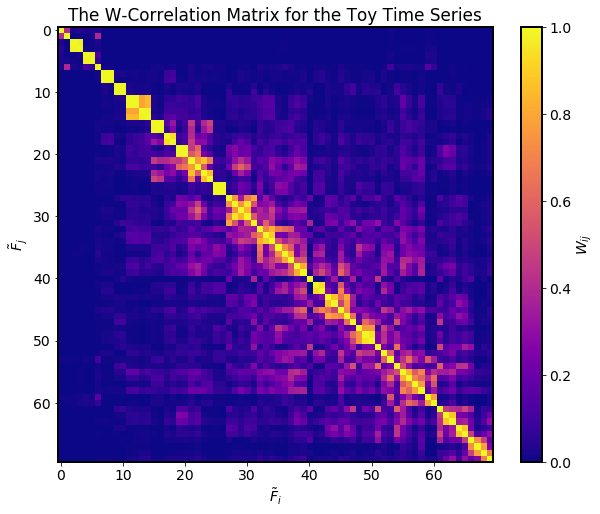

In [15]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Toy Time Series");

The structure of $\mathbf{W}_{\text{corr}}$ shows a lot of correlation between the time series components, particularly in the range $7 \le i,j \le 69$. As these were the components we classified as belonging to the noise in the time series, it is no surprise that there are non-negligible correlations between all of them; this is a natural result of the noise having no underlying structural component that can be further separated.

It is important to note that $\mathbf{W}_{\text{corr}}$ is roughly split into two 'blocks': $0 \le i,j \le 6$, and $7 \le i,j \le 69$. This corresponds to two main groupings: a smoothed time series (i.e. the trend plus the two periodic components), and the residual noise. Zooming into the first seven components in $\mathbf{W}_{\text{corr}}$:

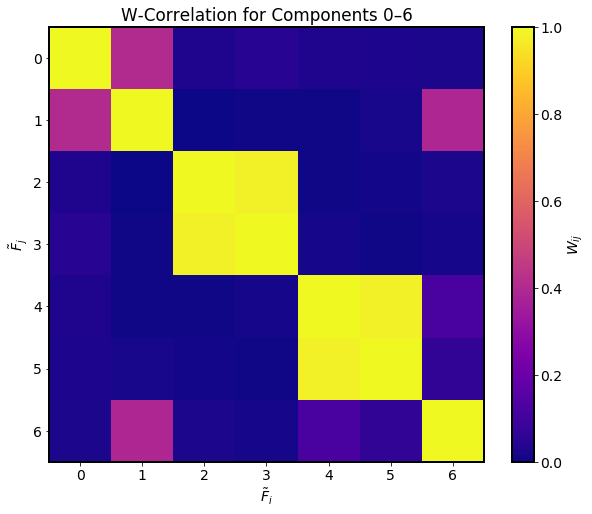

In [16]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6");

The initial appearance-based groupings we made for the first six components are supported by the corresponding w-correlation values. $\tilde{F}_0$ and $\tilde{F}_1$ have $W_{0,1} = 0.40$, suggesting they should be paired. $\tilde{F}_1$ and $\tilde{F}_6$ also have $W_{1,6} = 0.39$, suggesting $\tilde{F}_6$ should also be grouped with $\tilde{F}_0$ and $\tilde{F}_1$ as a trend component. However, $\tilde{F}_6$ also has a slight w-correlation with $\tilde{F}_4$ and $\tilde{F}_5$, but since $\tilde{F}_4$ and $\tilde{F}_5$ have no w-correlation with $\tilde{F}_0$ and $\tilde{F}_1$, we choose to keep $\tilde{F}_6$ with $\tilde{F}_0$ and $\tilde{F}_1$.

Our prior groupings of  $\tilde{F}^{\text{(periodic 1)}} = \tilde{F}_2 + \tilde{F}_3$ and $\tilde{F}^{\text{(periodic 2)}} = \tilde{F}_4 + \tilde{F}_5$ are clearly justified by the w-correlation matrix, with $W_{2,3} = 0.98$ and $W_{4,5} = 0.98$.

(Something to ponder:  the elementary components $\tilde{F}_2$ and $\tilde{F}_3$ for the toy time series are almost identical, except near the boundaries, where they diverge—see the plot *The First 12 Components of the Toy Time Series* further above. However, the w-correlation for $\tilde{F}_2$ and $\tilde{F}_3$ is almost equal to 1. Why hasn't the boundary divergence significantly impacted the w-correlation here?)

# 4. A Python Class for SSA<a name="Section4"></a>

So far, the lines of code written to perform SSA on a time series have been spread through a number of cells, and are far outnumbered by the lines of code written to generate pretty plots. It is time to collect the SSA code into a handy class, imaginatively named *`SSA`*, which will form the basis for the rest of this notebook. Each instance of the class will contain the decomposition of a time series for some window length $L$, and provide useful methods to analyse, plot and reconstruct the time series.

To summarise the SSA algorithm:
1. For a time series $F = (f_0, \ f_1, \ldots, \ f_{N-1})$, and a window length $L$, form the trajectory matrix $\mathbf{X}$, with columns given by the vectors $(f_i, \ldots, f_{L+i-1})^{\text{T}}$, $0 \le i \le N-L$.
2. Decompose $\mathbf{X}$ with the singular value decomposition, $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V^{\text{T}}_i$.
3. Construct the $d$ elementary matrices $\mathbf{X}_i = \sigma_i U_i V^{\text{T}}_i$.
4. Diagonally average the $\mathbf{X}_i$ to form the elementary time series components $\tilde{F}_i$, such that $F = \sum_{i=0}^{d-1} \tilde{F}_i$.
5. Calculate and store the weighted correlation matrix, $\mathbf{W}_{\text{corr}}$, for the $\tilde{F}_i$.

The task of grouping and classifying the elementary components $\tilde{F}_i$ is left to the user.

In [17]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

## 5. The Window Length<a name="Section5"></a>
We have now established the machinery to easily investigate the effect of the window length parameter, $L$, on the decomposition of our toy time series.

### 5.1 $L = 2$ <a name="Section5.1"></a>
A window length of 2 may seem like a useless choice, but it's a good place to start and watch the time series get decomposed into more and more components. We'll use the handy `SSA.components_to_df()` method to return a Pandas DataFrame and plot all elementary components at once.

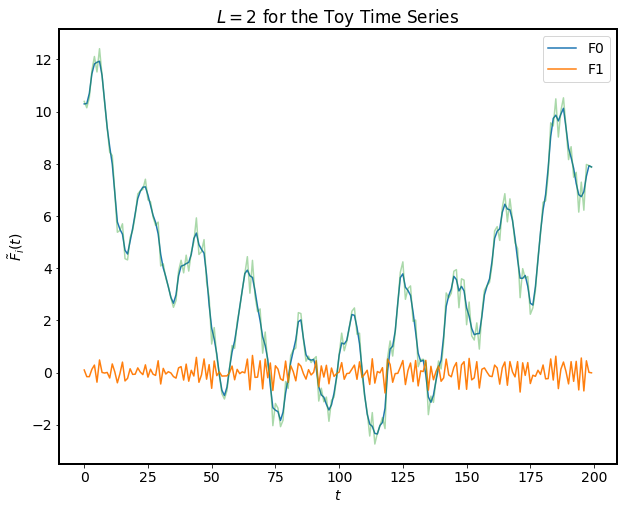

In [18]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series");

For $L=2$ we can only expect two elementary components to be returned. Even for such a small window length, the SSA algorithm has started to separate the high-frequency noise from the series, giving us a somewhat-denoised version of the original series in the component $\tilde{F}_0$.

## 5.2 $L = 5$<a name="Section5.2"></a>
Let's go up to a window length of 5, and see what happens to the elementary components:

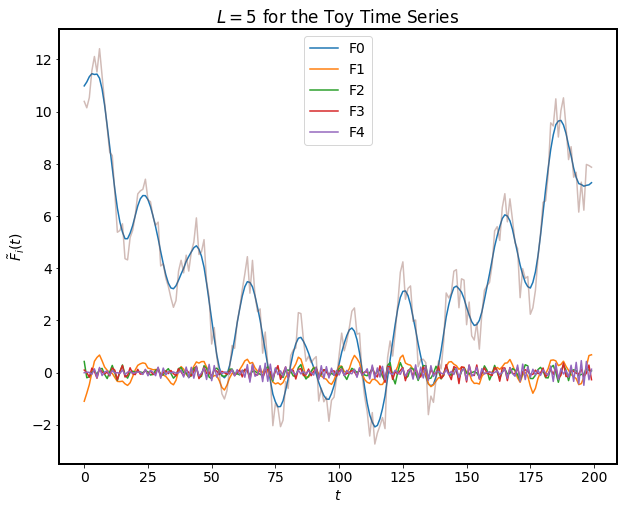

In [19]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Toy Time Series");
plt.show()

We see that $\tilde{F}_0$ is now a well-and-truly denoised version of the original series. $\tilde{F}_1$ is a poorly resolved periodic component, while $\tilde{F}_2$ to $\tilde{F}_4$ are just noise.

## 5.3 $L = 20$<a name="Section5.3"></a>

Let's quadruple the window length, and instead of inspecting elementary components, we'll look at the resulting w-correlation matrix and make some grouping decisions first.

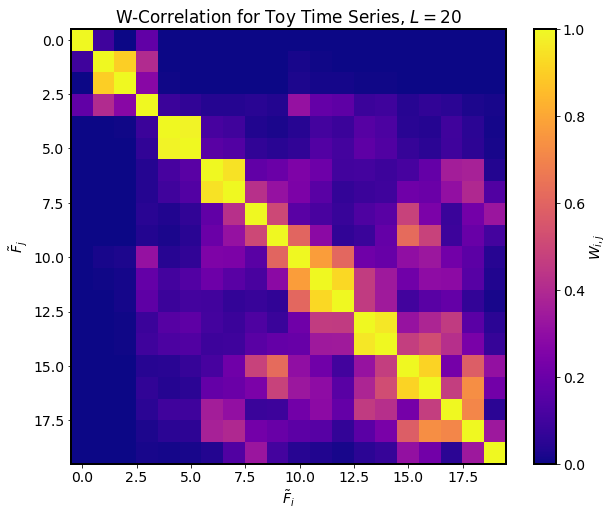

In [20]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=20$");

The w-correlation matrix for $L=20$ is split (roughly) into two blocks: $\tilde{F}_0$ to $\tilde{F}_3$, and $\tilde{F}_4$ to $\tilde{F}_{19}$. Within those blocks, the size of the $W_{i,j}$ values suggest that we need to group $\tilde{F}_1$, $\tilde{F}_2$ and $\tilde{F}_3$, and group all $ \tilde{F}_4, \ldots,\tilde{F}_{19}$. This grouping is certainly not ideal, as $\tilde{F}_3$ has non-negligible w-correlation with components in the second block. We'll plot our chosen component groupings, along with $\tilde{F}_3$ on its own, and see if we're justified in our choice of grouping: 

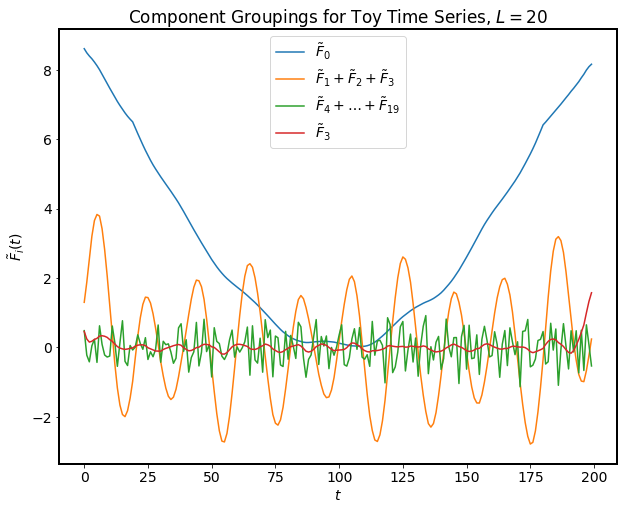

In [21]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

For $L = 20$ we begin to see the trend and periodic components start to take shape. The single component $\tilde{F}_0$ looks like the parabolic trend, and the group $\tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3$ is a very handsome periodicity, corresponding to the sum of the two periodic components in the original definition of the toy time series. The component $\tilde{F}_3$ is troublesome, looking like it contributes to both noise *and* periodicity. This suggests we need to increase the window length and see if we get an improved separation of noise and periodicity.

## 5.4 $L = 40$<a name="Section5.4"></a>

Once again, we'll double the window length and inspect the w-correlation matrix first.

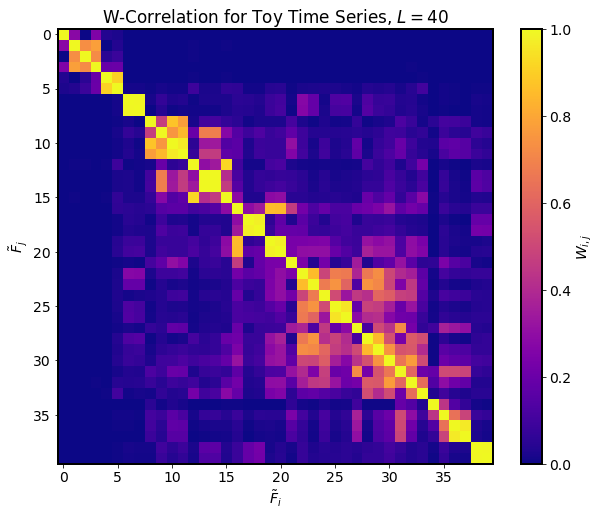

In [22]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=40$");

The w-correlation matrix for $L=40$ retains the two-block structure, with $\tilde{F}_0, \ldots, \tilde{F}_5$ in the first block, and $\tilde{F}_6, \ldots, \tilde{F}_{39}$ in the second. Let us group the components as follows:
\begin{align*}
    \tilde{F}^{(0)} & = \tilde{F}_0 \\
    \tilde{F}^{(1)} & = \tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3 \\
    \tilde{F}^{(2)} & = \tilde{F}_4 + \tilde{F}_5 \\
    \tilde{F}^{(3)} & = \tilde{F}_6 + \ldots + \tilde{F}_{39} \\
\end{align*}
Once again, it can be argued that this grouping is not ideal, given the non-negligible w-correlation between, for example,  $\tilde{F}_0$ and $\tilde{F}_1$. 

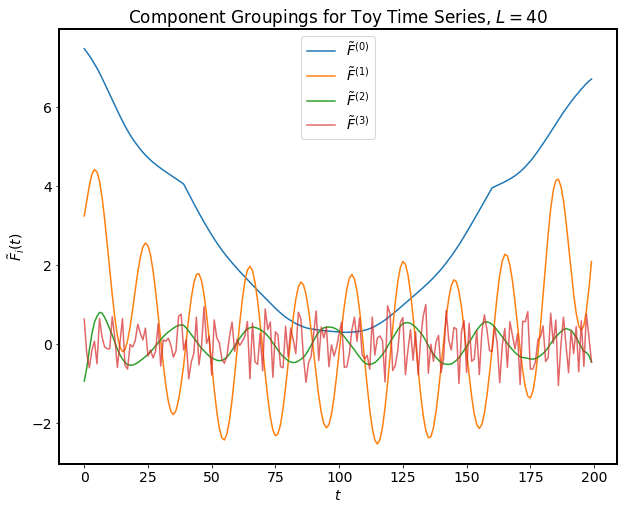

In [23]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3]).plot()
F_ssa_L40.reconstruct([4,5]).plot()
F_ssa_L40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.title("Component Groupings for Toy Time Series, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

Interestingly, the trend component $\tilde{F}^{(0)}$ has started to deteriorate at $L=40$, with notable 'kinks' in the time series. The periodicity in the toy series is now separated into two periodic components of differing amplitudes and frequencies, however with significant deteriorations near the beginning and end of the time series. At this stage our window length is 20% of the length of the time series, but the poor quality of the separated components suggests that we still need to increase the window size.

## 5.5 $L = 60$<a name="Section5.5"></a>
We are now approaching our first choice of $L=70$, so it's worth investigating how the decomposition converges to our original results. Inspect the w-correlation matrix first:

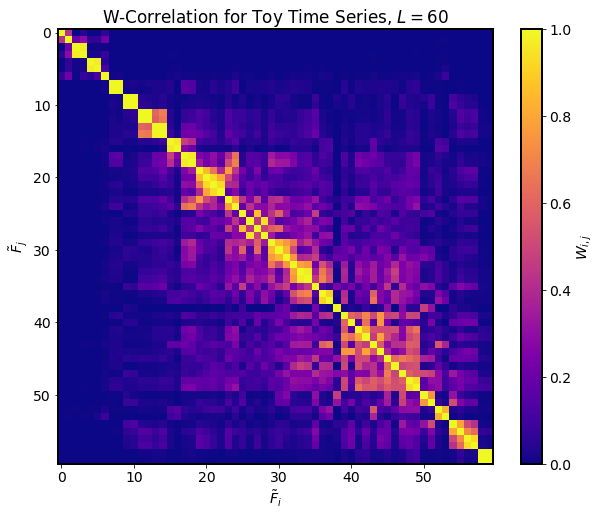

In [24]:
F_ssa_L60 = SSA(F, 60)
F_ssa_L60.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=60$");

As with the original $L=70$ result, the w-correlation matrix is now composed of two separate blocks: $\tilde{F}_0$ to $\tilde{F}_6$, and $\tilde{F}_7$ to $\tilde{F}_{59}$. From experience now, it is clear that $\tilde{F}^{\text{(signal)}} = \sum_{i=0}^6 \tilde{F}_i$ will be the combined trend and periodic components ('signal'), and $\tilde{F}^{\text{(noise)}} = \sum_{i=7}^{59} \tilde{F}_i$ will be the noise:

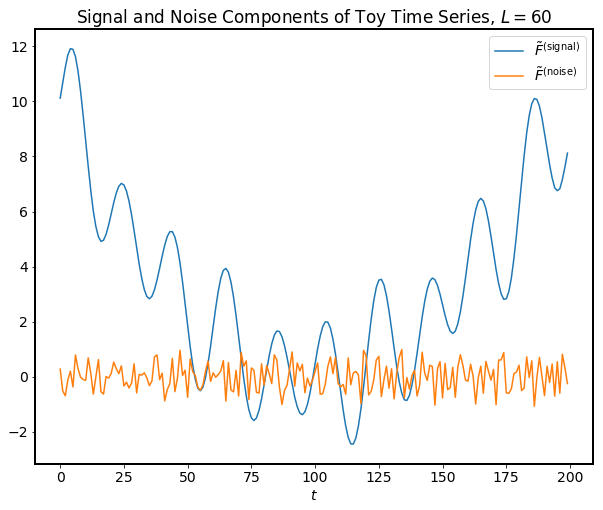

In [25]:
F_ssa_L60.reconstruct(slice(0,7)).plot()
F_ssa_L60.reconstruct(slice(7,60)).plot()
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.xlabel(r"$t$");

Viewing the w-correlation matrix for components 0–6:

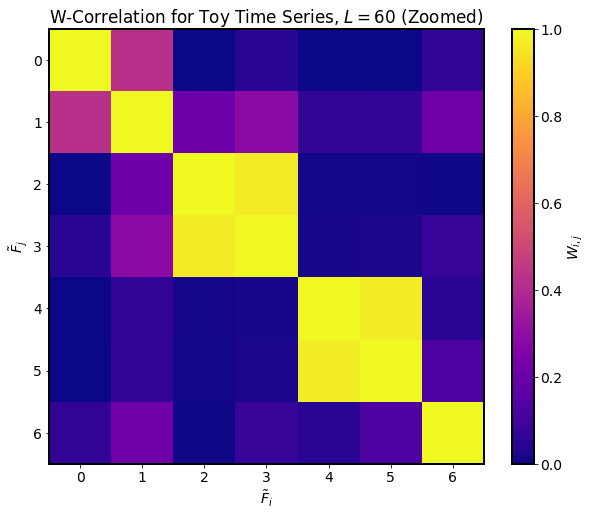

In [26]:
F_ssa_L60.plot_wcorr(max=6)
plt.title("W-Correlation for Toy Time Series, $L=60$ (Zoomed)");

To understand why there is non-negligible w-correlation between most of the first seven components, it'll be prudent to plot all of them at once:

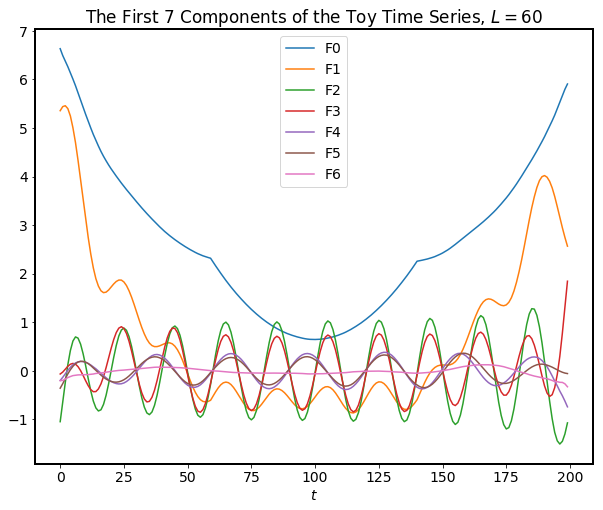

In [27]:
F_ssa_L60.components_to_df(n=7).plot()
plt.title(r"The First 7 Components of the Toy Time Series, $L=60$")
plt.xlabel(r"$t$");

It is clear from the plot above that the trend component $\tilde{F}_1$ contains oscillations that are the same frequency as the periodic components $\tilde{F}_2$ and $\tilde{F}_3$, resulting in substantial w-correlations. As we've already witnessed (see [Section 2.3](#Section2.3)), increasing the window length to $L = 70$ is enough to remove these oscillations almost entirely. It is certainly possible to increase the window length further—up to $L = N/2 = 100$ in this case—however, beyond $L=70$, the time series components generated by the leading seven eigentriples are (relatively) insensitive to the window length. 

In SSA, there are no hard and fast rules to setting the perfect window length, beyond $2 \le L \le N/2$. However, longer window lengths (up to 30–45% of the length of the time series) are sometimes required to adequately separate underlying periodicities from the overall trend. Some trial and error is needed, but it is often easy to start at a 'large-enough' window length, and work from there.

(Exercise: why is the window length $L$ restricted to the range $2 \le L \le N/2$? Hint: consider the expression for the SVD of the transposed trajectory matrix, $\mathbf{X}^{\text{T}} = \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}}$, for a trajectory matrix when $N/2 < L < N$.)    


## 6. MotionSense: Applying SSA to Accelerometer Data<a name="Section6"></a>

In this section, we'll leave the toy time series behind and apply SSA to real-world data. To this end, I have chosen the accelerometer time series recordings in the [MotionSense](https://www.kaggle.com/malekzadeh/motionsense-dataset) dataset. More specifically, I will use accelerometer readings taken from the smart phone of a study participant walking naturally. This data is suitable for the SSA treatment because walking is a rhythmic process, with periodicities that should present themselves on accelerometer recordings.

### 6.1 Loading the Data<a name="Section6.1"></a>
The time series we'll use are located in the directory `../input/A_DeviceMotion_data/A_DeviceMotion_data/wlk_15/`. The walking time series for each subject are contained in the `sub_*.csv` files. We'll load just Subject 1 for now:

In [28]:
walk_1 = pd.read_csv("../input/A_DeviceMotion_data/A_DeviceMotion_data/wlk_15/sub_1.csv")

The `userAcceleration.*` fields give the components of the instantaneous acceleration vector with respect to the fixed $x$, $y$ and $z$ coordinate axes, recorded by the participant's smart phone. For our purposes, we'll calculate the Euclidean norm of this vector—that is, we'll use the magnitude of the acceleration for our time series. The sampling rate for the measurements is 50 Hz, so we'll also transform the index to units of seconds:

In [29]:
cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
accel_1 = (walk_1[cols]**2).sum(axis=1)**0.5
accel_1.index /= 50

### 6.2 Plotting the Data<a name="Section6.2"></a>
Plot the time series for the magnitude of the acceleration:

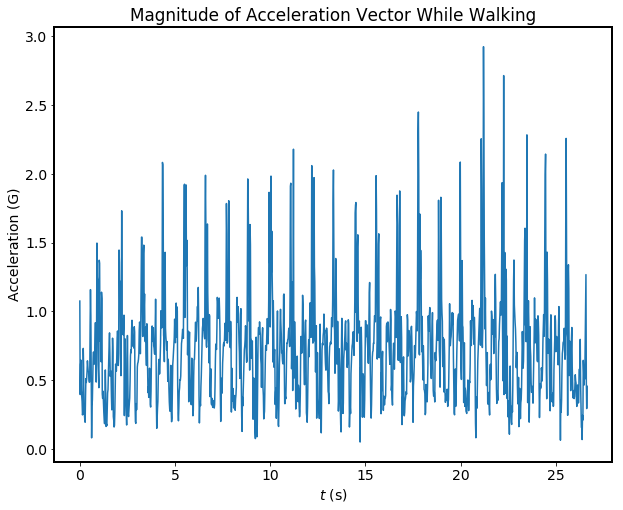

In [30]:
accel_1.plot()
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.title("Magnitude of Acceleration Vector While Walking");

The instantaneous acceleration over time while walking is quite periodic, as anticipated. While we won't attempt to link the regular patterns with the features of walking (i.e. foot-fall, foot-lift, leg-swing, etc.), we'll plot a few one-second cycles on top of each other to demonstrate the periodicity in the series:  

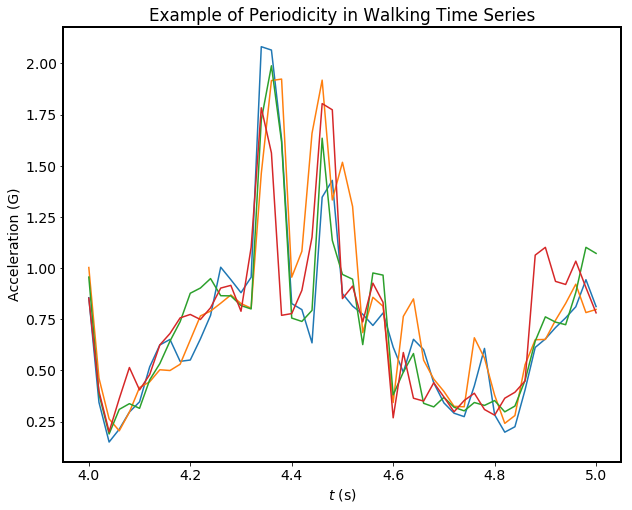

In [31]:
accel_1.loc[4:5].plot()
accel_1.shift(-56).loc[4:5].plot()
accel_1.shift(-112).loc[4:5].plot()
accel_1.shift(-168).loc[4:5].plot()

plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.title("Example of Periodicity in Walking Time Series");

### 6.3 Decomposing the Time Series With SSA<a name="Section6.3"></a>
As a demonstration, we'll pick a 15-second (750 samples) subseries from the acceleration time series, set a window length of 7 seconds (350 samples), and apply SSA: 

In [32]:
start = 10 # seconds, not samples
end = 25 # seconds
window = 350 # samples
accel_ssa = SSA(accel_1.loc[start:end], window)

As always, plot the w-correlation matrix first to help orient ourselves with the separated components.

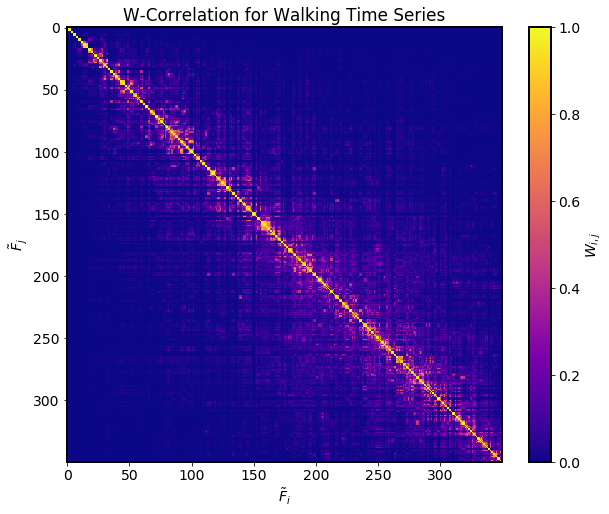

In [33]:
accel_ssa.plot_wcorr()
plt.title("W-Correlation for Walking Time Series");

Of course, with a larger window length (and therefore a large number of elementary components), such a view of the w-correlation matrix is not the most helpful. Zoom into the w-correlation matrix for the first 50 components:  

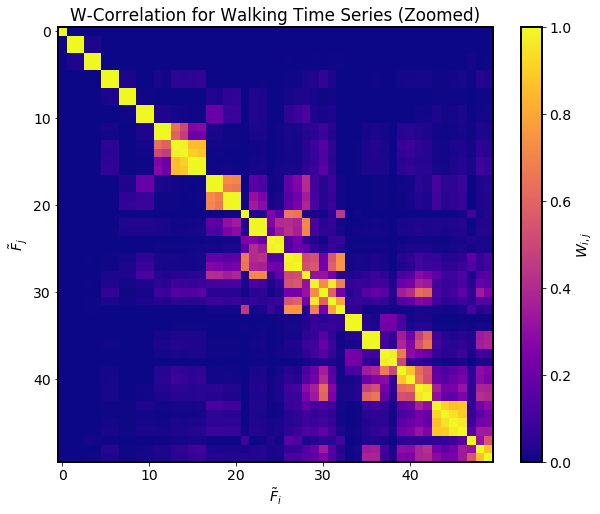

In [34]:
accel_ssa.plot_wcorr(max=49)
plt.title("W-Correlation for Walking Time Series (Zoomed)");

Beginning with the first five elementary components, we'll form the following groups and plot them:

\begin{align*}
    \tilde{F}^{(0)} & = \tilde{F}_0 \\
    \tilde{F}^{(1)} & = \tilde{F}_1 + \tilde{F}_2 \\
    \tilde{F}^{(2)} & = \tilde{F}_3 + \tilde{F}_4 \\
\end{align*}

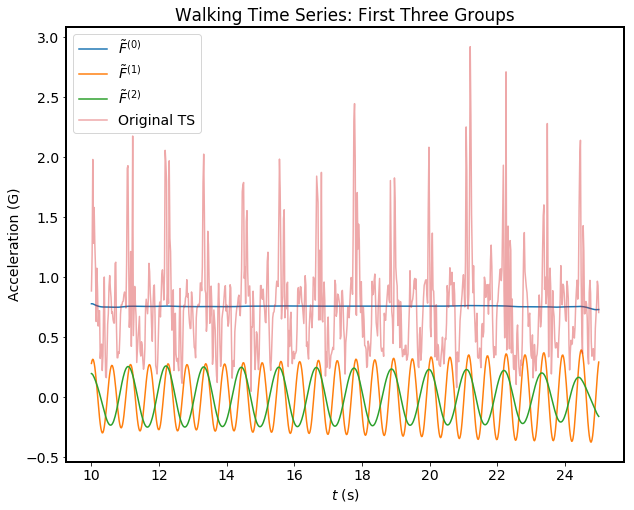

In [35]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

And zoom in on a four-second subseries: 

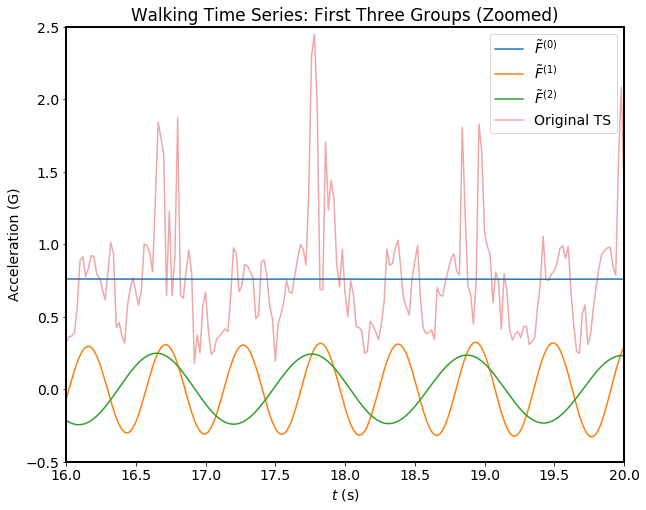

In [36]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(-0.5, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

It is clear from the two plots that the component $\tilde{F}^{(0)}$ is the trend, while $\tilde{F}^{(1)}$ and $\tilde{F}^{(2)}$ are two dominating periodicities. As the long-term trend is essentially flat, the subsequent components consist of deviations above and below zero. (Note: if you subtract the mean from the time series before decomposing with SSA, the trend component $\tilde{F}_0$ disappears.)

If we decide to add together the first five elementary components, we get a picture of the smooth, low-frequency periodicity present in the series:

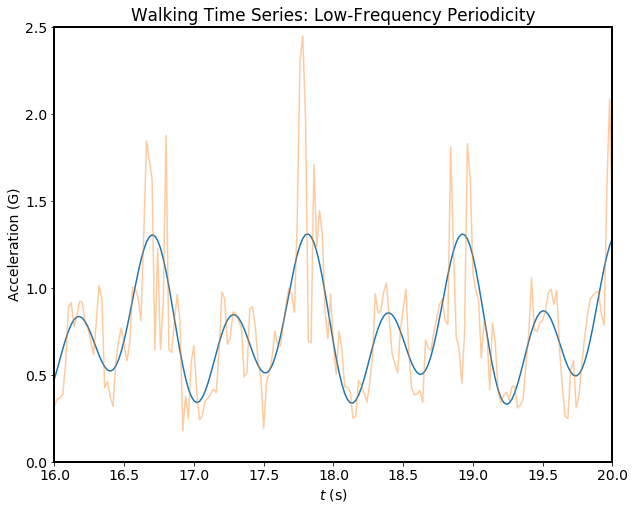

In [37]:
accel_ssa.reconstruct(slice(0,5)).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Low-Frequency Periodicity")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(0, 2.5);

Closer inspection of the original time series indicates that there are higher frequency periodicities present. Let's turn our attention to the elementary components $\tilde{F}_5$ to $\tilde{F}_{10}$. While these components all have some w-correlation with higher $i$ components, we'll make the following grouping:

\begin{align*}
    \tilde{F}^{(3)} & = \tilde{F}_5 + \tilde{F}_6 \\
    \tilde{F}^{(4)} & = \tilde{F}_7 + \tilde{F}_8 \\
    \tilde{F}^{(5)} & = \tilde{F}_9 + \tilde{F}_{10} \\
\end{align*}


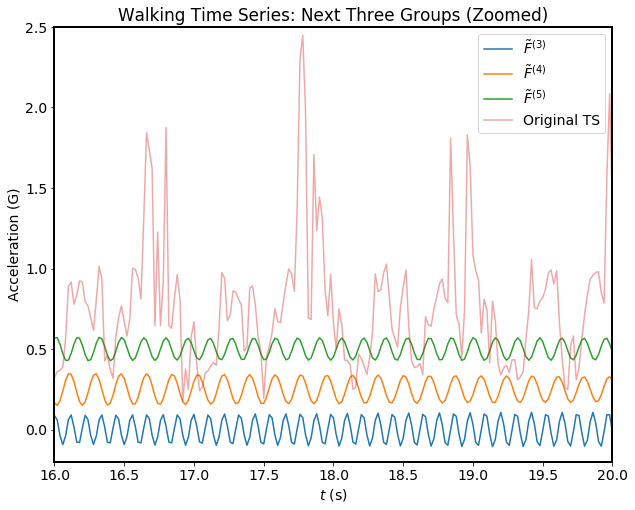

In [38]:
accel_ssa.reconstruct([5,6]).plot()
(accel_ssa.reconstruct([7,8]) + 0.25).plot() # Note: adding 0.25 to the series is for visualisation purposes only!
(accel_ssa.reconstruct([9,10]) + 0.5).plot() # Note: adding 0.5 to the series is for visualisation purposes only!
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Next Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(-0.2, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

The grouped components $\tilde{F}_3$, $\tilde{F}_4$ and $\tilde{F}_5$ are three further periodicities, with differing frequencies but approximately the same amplitudes.  In time series data with a lot of high-frequency components, SSA will typically generate a number of stable harmonic components that are well-separated from each other (i.e. low w-correlation). However, without some domain knowledge of the process generating the time series itself, it is difficult to say whether these components correspond to interpretable processes that operate independently, or if the set of components should be summed and treated as a single component. SSA is blind to reality. In this case, we'll sum these components together and inspect the periodicity they represent:

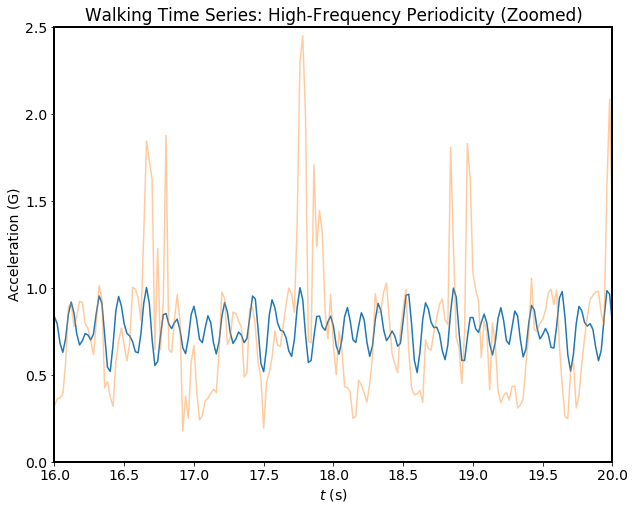

In [39]:
accel_ssa.reconstruct([0] + [i for i in range(5,11)]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: High-Frequency Periodicity (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.ylim(0, 2.5)
plt.xlim(16,20);

Combining the first 11 elementary components together, and plotting the remaining 339:

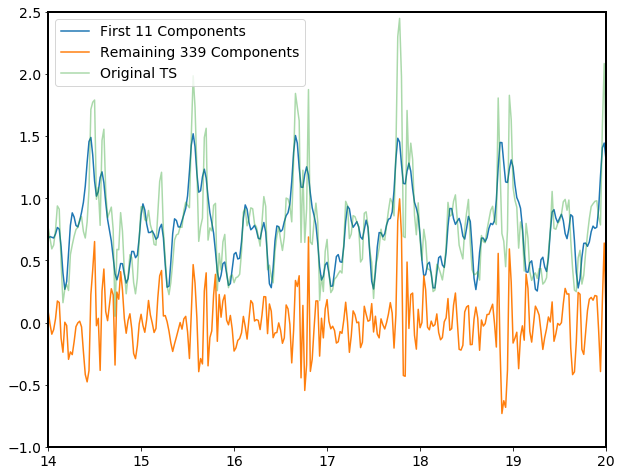

In [40]:
accel_ssa.reconstruct(slice(0,11)).plot()
accel_ssa.reconstruct(slice(11,350)).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.ylim(-1, 2.5)
plt.xlim(14,20)
plt.legend(["First 11 Components", "Remaining 339 Components", "Original TS"]);

The plot above demonstrates that the sum of the first 11 components adequately capture the basic, underlying periodicity of the accelerometer time series. However, the sum of the remaining 339 components (equivalent to the residual series $F_{\text{orig}} - \sum_{i=0}^{10} \tilde{F}_i$) still contains large, regular spikes spaced approximately 1 second apart, likely associated with the footfall events of walking. However, the basic form of SSA presented here does not handle these types of sharp periodicities very well, instead spreading the 'signal' from these periodicities across many elementary components. Put another way, the regular part of signal cannot be separated from the noise.  I cannot offer a solution here; instead, the problem at hand (whether it's exploratory analysis, signal extraction, data preprocessing...) will dictate how situations like this are treated.

### 6.4 Using SSA to Extract an Individual's Walking 'Signature' <a name="Section6.4"></a>
Pretend we were given a dataset consisting of unlabelled walking accelerometer time series—some of them from the same person, perhaps—and tasked with determining the number of individuals in the dataset. Let us suppose that everyone's walk has a unique 'signature' that can be extracted from accelerometer data. This signature could be compared across time series to determine whether the time series originates from the same person. Given the noise and complexity of the accelerometer time series, we therefore seek a way of extracting a simple, robust signature from the time series data.

The accelerometer time series we've seen so far contains a simple, regular low frequency component that can easily be extracted by SSA. The walking time series in the MotionSense dataset includes 24 different participants, walking on two separate occasions. We'll attempt to extract the 'signature' component from a handful of these series, and assess if it could act as an identifier for an individual. 

(This application of SSA has been inspired by the papers, [Persistent-homology-based gait recognition](https://arxiv.org/pdf/1707.06982.pdf) and, of course, the source of this dataset, [Protecting Sensory Data against Sensitive Inferences](https://arxiv.org/abs/1802.07802).) 

#### 6.4.1 Data Extraction and Processing<a name="Section6.4.1"></a>
Below is a subroutine that will extract and return the accelerometer time series for a given subject. The parameter, `walk`  (`= 1` or `2`), specifies which of the first or second walking time series should be loaded. The time series values are converted to z-scores.

SSA is then performed on the time series, using the same 15 second subseries and 7 second window length as before. The `SSA` object is then returned.

In [41]:
def extract_series(subject, walk):
    walk_dict = { 1 : "wlk_8", 2 : "wlk_15"}
    file_path = "../input/A_DeviceMotion_data/A_DeviceMotion_data/{}/".format(walk_dict[walk])
    file = "sub_{}.csv".format(subject)
    file_path += file
    walk = pd.read_csv(file_path)
    cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
    accel = (walk[cols]**2).sum(axis=1)**0.5
    
    # Convert acceleration values to z-scores.
    accel = (accel - accel.mean())/accel.std()
    
    # Convert index to units of seconds
    accel.index /= 50
    
    # Perform the SSA
    start = 10 # seconds, not samples
    end = 25 # seconds
    window = 350 # samples
    return SSA(accel.loc[start:end], window)

#### 6.4.2 Comparison of Walk 'Signatures'<a name="Section6.4.2"></a>
For this task, we'll only do an informal comparison of the walks from several participants. A more rigorous investigation would properly quantify time series similarity, ensure that the different time series are aligned as best as possible before comparison, and account for differences in walking pace. Here, we'll plot a few time series, compare them by eye, and call it a day. We will assume the low frequency components of interest are all contained in the first four eigentriples.

Based on the provided participants' characteristics [here](https://github.com/mmalekzadeh/motion-sense), the participants we'll examine are as follows:
* `3` and `5`—both females with almost-identical weights and heights;
* `21`—male with similar age, height and weight to participants `3` and `5`; and
* `1` and `22`—two males with similar heights and weights, approximately twice as heavy as participants `3`, `5` and `21`.


In [42]:
subjects = [3,5,21,1,22]
subject_ssa = {}

# Load and process the time series for each participant, storing the SSA objects.
# This will take a minute or two.
for subject in subjects:
    print("Subject #{}".format(subject))
    subject_ssa[subject] = extract_series(subject, 1), extract_series(subject, 2)

Subject #3
Subject #5
Subject #21
Subject #1
Subject #22


Plot all of the extracted 'signatures', using the first four eigentriples of the SSA decomposition:

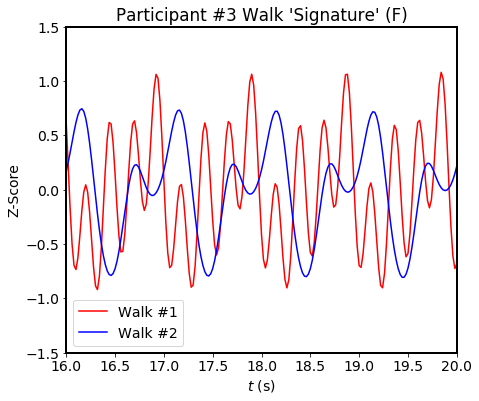

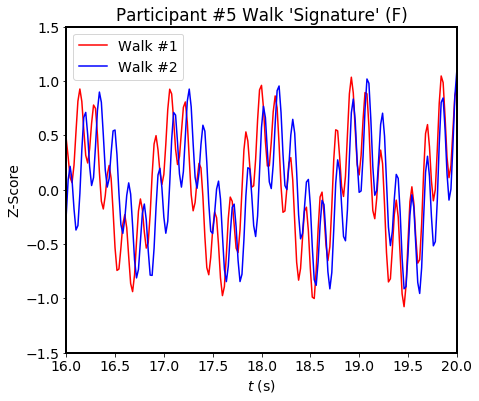

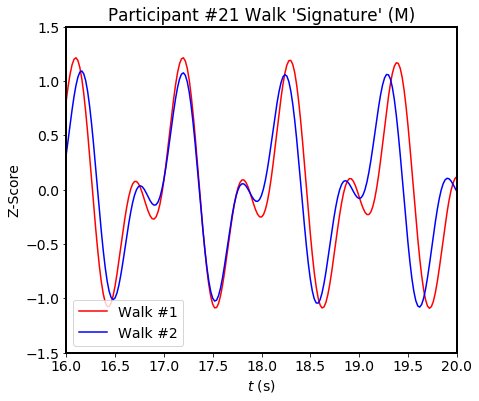

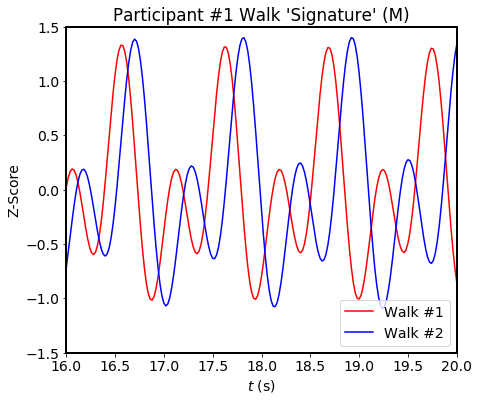

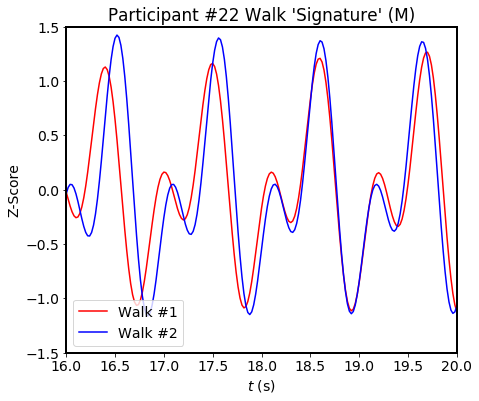

In [43]:
genders = ["F"]*2 + ["M"]*3
for subject, gender in zip(subjects, genders):
    ssa_1, ssa_2 = subject_ssa[subject]
    ssa_1.reconstruct(slice(0,4)).plot(color='red', figsize=(7,6))
    ssa_2.reconstruct(slice(0,4)).plot(color='blue')
    plt.xlim(16,20)
    plt.ylim(-1.5,1.5)
    plt.title("Participant #{} Walk 'Signature' ({})".format(subject, gender))
    plt.legend(["Walk #1", "Walk #2"])
    plt.xlabel(r"$t$ (s)")
    plt.ylabel("Z-Score")
    plt.show()

With the exception of Participant 3, the 'signature' extracted from the participants' walks are almost identical between Walk 1 and Walk 2, their relative offsets notwithstanding. While the overall time series for the male participants are very similar, we could derive some form of similarity measure to discriminate between them. (Serrà and Arcos provide a review of time series similarity measures [here](https://arxiv.org/pdf/1401.3973.pdf)).

While this is a very rudimentary approach to discriminating between identities in time series data, it demonstrates how SSA can be easily applied to extract simple features from complicated, noisy time series.

# 7. Some Final Words<a name="Section7"></a>
Through a relatively straightforward process of embedding, decomposition and reconstruction, the technique of **singular-spectrum analysis** can extract the trend of a time series, separate underlying periodicities and remove noise. It can be used as an exploratory tool, or in the context of a more detailed analysis. 

This kernel has presented both the theory and implementation of singular-spectrum analysis, and applied it to a number of time series. Please feel free to use and extend the `SSA` Python class ([Section 4](#Section4)) in other Kaggle kernels and projects—just provide a note and link to this kernel as a source.

The version of singular-spectrum analysis presented here is typically termed *basic SSA*, as a number of variants and extensions to the method have been developed. Singular-spectrum analysis can also be used for forecasting, and detecting structural changes in a time series—that is, detecting where a time series has been perturbed and taken on a new 'behaviour'. Multivariate and 2D versions of singular-spectrum analysis also exist... unfortunately, this notebook is already too long as it is.

If you have read this far, I thank you for your persistence. I hope this kernel has done justice to this wonderful method of time series analysis.